### 【#10】クロス特徴量

In [1]:
# 通常の pandas 動作が倍速になる
%load_ext cudf.pandas

In [2]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import os
import cudf
from cuml.preprocessing import TargetEncoder

# データフレーム読み込み
train_df = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")
TARGET = "BeatsPerMinute"

In [3]:
# 前処理前の相関分布を確認
import seaborn as sns
import matplotlib.pyplot as plt

# BPMを周期的に扱う
train_df["BPM_sin60"] = np.sin(2*np.pi*train_df[TARGET]/60)
train_df["BPM_cos60"] = np.cos(2*np.pi*train_df[TARGET]/60)

# 相関係数の確認
df_corr = train_df.drop("id",axis=1).corr()
df_corr[["BeatsPerMinute","BPM_sin60","BPM_cos60"]]
# グラフ表示
# fig, ax = plt.subplots(figsize=(8, 6)) 
# sns.heatmap(df_corr, mask=df_corr.isnull(), cmap="inferno", square=True, vmax=1, vmin=-1, center=0, annot=True)

,BeatsPerMinute,BPM_sin60,BPM_cos60
RhythmScore,0.005440,0.001740,0.000858
AudioLoudness,-0.003327,0.003813,-0.001307
VocalContent,0.004876,-0.000153,0.000820
AcousticQuality,-0.000820,-0.002490,0.000240
InstrumentalScore,0.001900,0.000799,0.002295
LivePerformanceLikelihood,0.003471,0.000891,0.003175
MoodScore,0.007059,0.001023,0.003620
TrackDurationMs,0.006637,-0.002392,0.003216
Energy,-0.004375,0.006441,0.000348
BeatsPerMinute,1.000000,0.072929,0.016652


In [4]:
# from sklearn.feature_selection import mutual_info_regression

# # 相互情報量の計算
# mi_scores = mutual_info_regression(train_df.drop(["id",TARGET],axis=1), 
#                                    train_df[TARGET], random_state=42)

# # 結果をDataFrame化してソート
# mi_df = pd.DataFrame({
#     "feature": train_df.drop(["id",TARGET],axis=1).columns,
#     "mutual_info": mi_scores
# }).sort_values(by="mutual_info", ascending=False)

# print(mi_df)

In [5]:
# 初期値に戻す
train_df = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")

In [6]:
from sklearn.preprocessing import MinMaxScaler

## [dB]表記を直値に戻す LdBFS = 20*log10(|x|/xmax)
# 戻すには 10^(dBFS/20) * xmax
train_df["AudioLoudness"] = 10**(train_df["AudioLoudness"]/20)
test_df["AudioLoudness"] = 10**(test_df["AudioLoudness"]/20)

# TrackDurationMs (ms → minute)
train_df["TrackDurationMs"] = train_df["TrackDurationMs"] / 1000 / 60
test_df["TrackDurationMs"] = test_df["TrackDurationMs"] / 1000 / 60

# 規格化する
scaler = MinMaxScaler()
for col in train_df.drop(["id",TARGET],axis=1).columns:

    train_df[col] = scaler.fit_transform(train_df[col].values.reshape(-1, 1))
    test_df[col] = scaler.transform(test_df[col].values.reshape(-1, 1))

In [7]:
# データ結合
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [8]:
# bin化する
bins = [0, 0.2, 0.4, 0.6, 0.8, all_df.drop(["id",TARGET],axis=1).max().max()]
labels = ["VeryLow","Low","Mid","High","VeryHigh"]
# labels = list(range(5))
for col in train_df.drop(["id",TARGET],axis=1).columns:
    all_df[col+"_bin"] = pd.cut(all_df[col], bins=bins,
                                labels=labels, include_lowest=True).astype("object")

In [9]:
# カテゴリ列と数値列に分ける
CATS = []
NUMS = []
for c in (all_df.drop(["id",TARGET],axis=1)).columns:
    t = "CAT"
    if all_df[c].dtype=='object':
        CATS.append(c)
    else:
        NUMS.append(c)
        t = "NUM"
    n = all_df[c].nunique()
    na = all_df[c].isna().sum()
    print(f"[{t}] {c} has {n} unique and {na} NA")
print("CATS:", CATS )
print("NUMS:", NUMS )

[NUM] RhythmScore has 420960 unique and 0 NA
[NUM] AudioLoudness has 408208 unique and 0 NA
[NUM] VocalContent has 297350 unique and 0 NA
[NUM] AcousticQuality has 353187 unique and 0 NA
[NUM] InstrumentalScore has 285676 unique and 0 NA
[NUM] LivePerformanceLikelihood has 364273 unique and 0 NA
[NUM] MoodScore has 400518 unique and 0 NA
[NUM] TrackDurationMs has 496440 unique and 0 NA
[NUM] Energy has 11980 unique and 0 NA
[CAT] RhythmScore_bin has 5 unique and 0 NA
[CAT] AudioLoudness_bin has 5 unique and 0 NA
[CAT] VocalContent_bin has 5 unique and 0 NA
[CAT] AcousticQuality_bin has 5 unique and 0 NA
[CAT] InstrumentalScore_bin has 5 unique and 0 NA
[CAT] LivePerformanceLikelihood_bin has 5 unique and 0 NA
[CAT] MoodScore_bin has 5 unique and 0 NA
[CAT] TrackDurationMs_bin has 5 unique and 0 NA
[CAT] Energy_bin has 5 unique and 0 NA
CATS: ['RhythmScore_bin', 'AudioLoudness_bin', 'VocalContent_bin', 'AcousticQuality_bin', 'InstrumentalScore_bin', 'LivePerformanceLikelihood_bin', 'Moo

In [10]:
# カテゴリ列をラベルエンコードする
# NUMS：数値列、NUMS2：カテゴリ数、CATS1：カテゴリ数
CATS1 = [] # 数値列
SIZES = {} # カテゴリ数

for c in NUMS + CATS:
    n = c
    # 数値列のとき
    if c in NUMS: 
        n = f"{c}2"
        CATS1.append(n)
    # カテゴリ列のとき、ラベルエンコード
    all_df[n],_ = all_df[c].factorize()
    # カテゴリ数
    SIZES[n] = all_df[n].max()+1

    # print(c)
    all_df[c] = all_df[c].astype('int32')
    all_df[n] = all_df[n].astype('int32')

print("New CATS:", CATS1 )
print("Cardinality of all CATS:", SIZES )

New CATS: ['RhythmScore2', 'AudioLoudness2', 'VocalContent2', 'AcousticQuality2', 'InstrumentalScore2', 'LivePerformanceLikelihood2', 'MoodScore2', 'TrackDurationMs2', 'Energy2']
Cardinality of all CATS: {'RhythmScore2': 420960, 'AudioLoudness2': 408208, 'VocalContent2': 297350, 'AcousticQuality2': 353187, 'InstrumentalScore2': 285676, 'LivePerformanceLikelihood2': 364273, 'MoodScore2': 400518, 'TrackDurationMs2': 496440, 'Energy2': 11980, 'RhythmScore_bin': 5, 'AudioLoudness_bin': 5, 'VocalContent_bin': 5, 'AcousticQuality_bin': 5, 'InstrumentalScore_bin': 5, 'LivePerformanceLikelihood_bin': 5, 'MoodScore_bin': 5, 'TrackDurationMs_bin': 5, 'Energy_bin': 5}


In [11]:
# カラムペアの作成
from itertools import combinations

pairs = combinations(CATS + CATS1, 2)
new_cols = {}
CATS2 = []

for c1, c2 in pairs:
    name = "_".join(sorted((c1, c2)))
    new_cols[name] = all_df[c1] * SIZES[c2] + all_df[c2]
    CATS2.append(name)
if new_cols:
    new_df = pd.DataFrame(new_cols)         
    all_df = pd.concat([all_df, new_df], axis=1) 

print(f"Created {len(CATS2)} new CAT columns")

Created 153 new CAT columns


In [12]:
# カウントエンコード
# yの値ではなく、存在しか使っていない。リークにはならない
CE = []
CC = CATS+CATS1+CATS2

print(f"Processing {len(CC)} columns... ",end="")
for i,c in enumerate(CC):
    if i%10==0: print(f"{i}, ",end="")
    tmp = all_df.groupby(c).BeatsPerMinute.count()
    tmp = tmp.astype('int32')
    tmp.name = f"CE_{c}"
    CE.append( f"CE_{c}" )
    all_df = all_df.merge(tmp, on=c, how='left')
print()

Processing 171 columns... 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 


In [13]:
# メモリ開放
import gc
del tmp
gc.collect()

0

In [14]:
# データ分割
train = all_df.iloc[:len(train_df)]
test = all_df.iloc[len(train_df):]

In [15]:
# yがint64なのでint32に変換する
train[TARGET] = train[TARGET].astype("int32")

In [16]:
# # 前処理前の相関分布を確認
# import seaborn as sns
# import matplotlib.pyplot as plt

# # BPMを周期的に扱う
# train["BPM_sin60"] = np.sin(2*np.pi*train[TARGET]/60)
# train["BPM_cos60"] = np.cos(2*np.pi*train[TARGET]/60)

In [17]:
# # 1. inf を NaN に変換
# train_clean = train.replace([np.inf, -np.inf], np.nan)

# # 2. NaN を埋める（全部0にする例）
# train_clean = train_clean.fillna(0)

# # 3. 分散ゼロの列を除去
# non_constant_cols = train_clean.loc[:, train_clean.std() != 0]

# # 相関係数の確認
# df_corr = non_constant_cols.drop("id",axis=1).corr()

In [18]:
# # BeatsPerMinuteでソート
# df_corr["BeatsPerMinute"].sort_values(ascending=False)[:5]

In [19]:
# # BPM_sin60でソート
# df_corr["BPM_sin60"].sort_values(ascending=False)[:5]

In [20]:
# # BPM_cos60でソート
# df_corr["BPM_cos60"].sort_values(ascending=False)[:5]

In [21]:
###################################################
############ Light GBM with OOF Target Encoding ###
###################################################
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold
from category_encoders import TargetEncoder
from cuml.preprocessing import TargetEncoder
import cudf
import warnings
import gc
warnings.filterwarnings("ignore")

# 学習、バリデーションデータ
pred_lgb = np.zeros(len(train))
pred_lgb_test = np.zeros(len(test))
models_lgb = []

# 入力データ
X = train.drop(["id",TARGET], axis=1).copy()
y = train[TARGET].copy()
test_ = test.drop(["id",TARGET], axis=1).copy()

# 評価履歴を格納する辞書
evals_result_lgb = {}

# LightGBMパラメータ
lgbm_params = {
    'objective': 'regression',
    'device': 'gpu',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': 7,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'min_data_in_leaf': 200,
    'lambda_l1': 0.1,
    'lambda_l2': 1.0,
    'max_bin': 255,
    'verbosity': -1
}


# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=7, shuffle=True, random_state=42)

# Fold分割し格納
for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print("#"*25)
    print(f"### Fold {fold+1}")
    print("#"*25)

    X_train = X.iloc[train_idx,:].copy()
    y_train = y.iloc[train_idx].copy()
    X_valid = X.iloc[valid_idx,:].copy()
    y_valid = y.iloc[valid_idx].copy()
    X_test = test_.copy()

    # ターゲットエンコーディング
    CC = CATS1+CATS2
    print(f"Target encoding {len(CC)} features... ",end="")
    for i,c in enumerate(CC):
        if i%10==0: print(f"{i}, ",end="")
        TE0 = TargetEncoder(n_folds=10, smooth=10, split_method='random', stat='mean')
        X_train[c] = TE0.fit_transform(X_train[c],y_train).astype('float32')
        X_valid[c] = TE0.transform(X_valid[c]).astype('float32')
        X_test[c] = TE0.transform(X_test[c]).astype('float32')
    print()

    # TE0を明示的に削除
    del TE0
    gc.collect()

    # CC以外はカテゴリ型に変換
    for c in CATS:
        if c not in CC:  
            X_train[c] = X_train[c].astype('category')
            X_valid[c] = X_valid[c].astype('category')
            X_test[c]  = X_test[c].astype('category')    

    # データセット
    lgb_train = lgb.Dataset(
        X_train,y_train,categorical_feature=CATS)

    lgb_valid = lgb.Dataset(
        X_valid,y_valid,categorical_feature=CATS)
    # --------------------------
    # 学習
    # --------------------------
    model_lgb = lgb.train(
        lgbm_params,
        lgb_train,
        num_boost_round=2000,
        valid_sets=[lgb_train, lgb_valid],
        valid_names=["train", "valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.record_evaluation(evals_result_lgb),
            lgb.log_evaluation(100),
        ]
    )

    # 予測
    pred_lgb[valid_idx] = model_lgb.predict(
        X_valid, num_iteration=model_lgb.best_iteration)

    pred_lgb_test += model_lgb.predict(
        X_test, num_iteration=model_lgb.best_iteration)/7

    # モデル保存
    models_lgb.append(model_lgb)

    # メモリ開放
    del X_train, X_valid
    gc.collect()

    # メモリ開放
    import numba.cuda as cuda
    cuda.current_context().deallocations.clear()   

#########################
### Fold 1
#########################
Target encoding 162 features... 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[100]	train's rmse: 26.4361	valid's rmse: 26.4809
[200]	train's rmse: 26.4115	valid's rmse: 26.4807
#########################
### Fold 2
#########################
Target encoding 162 features... 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 
[100]	train's rmse: 26.4486	valid's rmse: 26.403
[200]	train's rmse: 26.4235	valid's rmse: 26.4028
[300]	train's rmse: 26.4004	valid's rmse: 26.4026
#########################
### Fold 3
#########################
Target encoding 162 features... 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 
[100]	train's rmse: 26.4315	valid's rmse: 26.5036
[200]	train's rmse: 26.4061	valid's rmse: 26.5045
#########################
### Fold 4
#########################
Target encoding 162 features... 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 
[100]	train's rmse: 26.4172	valid's rmse: 26.5971
#########################
### Fold 5
#########################
Target encoding 162 features

LGB: RMSE score = 26.46345720839192


<Axes: title={'center': 'LightGBM RMSE'}, xlabel='Iterations', ylabel='rmse'>

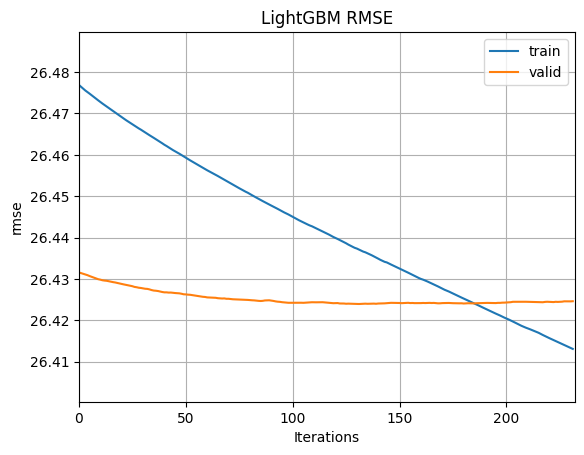

In [22]:
# 訓練データのスコア
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

RMSE_lgb = np.sqrt(mean_squared_error(y,pred_lgb))
print(f"LGB: RMSE score = {RMSE_lgb}")

# 学習曲線
lgb.plot_metric(evals_result_lgb,title="LightGBM RMSE",)

In [23]:
# 各FOLD、SEEDの平均
feature = 0
for i in range(7):
    feature += pd.DataFrame(models_lgb[i].feature_importance(importance_type="gain"),index=X.columns,columns=['importance'])/7

feature.sort_values("importance", ascending=False)[-20:]

,importance
InstrumentalScore_bin,8090.514300
CE_AudioLoudness2_MoodScore2,8049.275670
CE_AudioLoudness2_RhythmScore2,6941.047294
CE_RhythmScore2_TrackDurationMs2,6600.110212
CE_MoodScore2_RhythmScore2,4954.414342
CE_Energy2_RhythmScore2,4440.402902
CE_VocalContent_bin,3691.221470
CE_LivePerformanceLikelihood_bin,3487.834263
CE_InstrumentalScore_bin,1591.799944
CE_MoodScore2_TrackDurationMs2,1442.457171


In [24]:
# 提出データ作成
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e9/sample_submission.csv")

sample_submission[TARGET] = pred_lgb_test
sample_submission.to_csv('submission.csv', index=False)
print('Submission file saved.')

Submission file saved.


In [25]:
# # ============================================
# # 3. BPM_bin を分類タスクとして学習
# # ============================================
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import KFold

# # 入力データ
# X = train[features]
# y = train["BeatsPerMinute"]
# # y = train["BPM_bin"]

# # 評価履歴を格納する辞書
# evals_result_lgb = {}

# # パラメータ
# lgbm_params = {
#     'objective': 'regression',
#     "device": "cpu",
#     # "device": "gpu",
#     'metric': 'rmse',
#     'verbose': -1,              # ログ出力の制御
#     'boosting_type': 'gbdt',
#     'learning_rate': 0.01,
#     # 'feature_fraction': 0.6956717916553479,
#     # 'num_leaves':       153,
#     # 'bagging_fraction': 0.5279852787927486,
#     # 'bagging_freq':     4,
#     # 'lambda_l1':        0.004603414256652151,
#     # 'lambda_l2':        0.013858762846118894,
#     # 'min_data_in_leaf': 87,
#     }

# # パラメータ
# # lgbm_params = {
# #     'objective': 'multiclass',
# #     "num_class": 7,
# #     "device": "cpu",
# #     # "device": "gpu",
# #     'metric': 'multi_logloss',
# #     'verbose': -1,              # ログ出力の制御
# #     'boosting_type': 'gbdt',
# #     'learning_rate': 0.01,
# #     "num_leaves": 63,
# #     "max_depth": -1,
# #     "min_data_in_leaf": 20,
# # }

# # 学習、バリデーションデータ
# # oof_pred = np.zeros((len(train), 7))
# # test_pred = np.zeros((len(test), 7))
# oof_pred = np.zeros(len(train))
# test_pred = np.zeros(len(test))
# models_lgb = []

# # クロスバリデーション
# # skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# for fold,(train_idx,valid_idx) in enumerate(kf.split(X)):

#     print("#"*25)
#     print(f"### Fold {fold+1}")
#     print("#"*25)
    
#     X_train_kf = X.iloc[train_idx,:]
#     y_train_kf = y.iloc[train_idx]
#     X_valid_kf = X.iloc[valid_idx,:]
#     y_valid_kf = y.iloc[valid_idx]
    
#     # データセット作成
#     lgb_train_lgb = lgb.Dataset(X_train_kf,y_train_kf)
#     lgb_valid_lgb = lgb.Dataset(X_valid_kf,y_valid_kf)
#     # lgb_train_lgb = lgb.Dataset(X_train_kf,label=y_train_kf)
#     # lgb_valid_lgb = lgb.Dataset(X_valid_kf,label=y_valid_kf,reference=lgb_train_lgb)

#     # 学習
#     model_lgb = lgb.train(
#         lgbm_params,
#         lgb_train_lgb,
#         num_boost_round=2000,
#         valid_sets=[lgb_train_lgb,lgb_valid_lgb],
#         valid_names=["train","valid"],
#         callbacks=[
#             lgb.early_stopping(stopping_rounds=100,verbose=False),
#             lgb.record_evaluation(evals_result_lgb),
#             lgb.log_evaluation(100),])

#     # 各foldでのバリデーション予測
#     oof_pred[valid_idx] = model_lgb.predict(
#         X_valid_kf, num_iteration=model_lgb.best_iteration) 
    
#     # モデルの追加
#     models_lgb.append(model_lgb)

#     # テストの予測
#     test_pred = test_pred + model_lgb.predict(
#         test[features], num_iteration=model_lgb.best_iteration) / 5

In [26]:
# # 訓練データのスコア
# # from sklearn.metrics import f1_score
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt

# # 学習曲線
# lgb.plot_metric(evals_result_lgb,title="LightGBM RMSE",)

In [27]:
# 順番は評価出来ているのか...

In [28]:
# # ============================================
# # 5. 各 bin ごとの中央値を使って差し引き
# # ============================================
# cluster_median = {}
# for col in features:
#     cluster_median[col] = train.groupby("BPM_bin_pred")[col].median().to_dict()

# # 訓練データ：各特徴量から bin 中央値を差し引く
# for col in features:
#     train[col + "_centered"] = train.apply(
#         lambda x: x[col] - cluster_median[col].get(x["BPM_bin_pred"], 0),
#         axis=1
#     )

# # テストデータも同様
# for col in features:
#     test[col + "_centered"] = test.apply(
#         lambda x: x[col] - cluster_median[col].get(x["BPM_bin_pred"], 0),
#         axis=1
#     )

In [29]:
# ###################################################
# ############ Light GBM ############################
# ###################################################
# import lightgbm as lgb
# from sklearn.model_selection import KFold

# # 学習、バリデーションデータ
# pred_lgb = np.zeros(len(train_df))
# pred_lgb_test = np.zeros(len(test_df))
# models_lgb = []

# # 入力データ
# X = X_train.copy()
# y = train["BeatsPerMinute"].copy()

# # X = X_train
# # y = y_train
# # y = y_scaled

# # 評価履歴を格納する辞書
# evals_result_lgb = {}

# # パラメータ
# lgbm_params = {
#     'objective': 'regression',
#     "device": "cpu",
#     # "device": "gpu",
#     'metric': 'rmse',
#     'verbose': -1,              # ログ出力の制御
#     'boosting_type': 'gbdt',
#     'learning_rate': 0.01,
#     # 'feature_fraction': 0.6956717916553479,
#     # 'num_leaves':       153,
#     # 'bagging_fraction': 0.5279852787927486,
#     # 'bagging_freq':     4,
#     # 'lambda_l1':        0.004603414256652151,
#     # 'lambda_l2':        0.013858762846118894,
#     # 'min_data_in_leaf': 87,
#     }

# # クロスバリデーション
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# for fold,(train_idx,valid_idx) in enumerate(kf.split(X)):

#     print("#"*25)
#     print(f"### Fold {fold+1}")
#     print("#"*25)
    
#     X_train_kf = X.iloc[train_idx,:]
#     y_train_kf = y.iloc[train_idx]
#     X_valid_kf = X.iloc[valid_idx,:]
#     y_valid_kf = y.iloc[valid_idx]
    
#     # データセット作成
#     lgb_train_lgb = lgb.Dataset(X_train_kf,y_train_kf)
#     lgb_valid_lgb = lgb.Dataset(X_valid_kf,y_valid_kf)


#     # 学習
#     model_lgb = lgb.train(
#         lgbm_params,
#         lgb_train_lgb,
#         num_boost_round=2000,
#         valid_sets=[lgb_train_lgb,lgb_valid_lgb],
#         valid_names=["train","valid"],
#         callbacks=[
#             lgb.early_stopping(stopping_rounds=100,verbose=False),
#             lgb.record_evaluation(evals_result_lgb),
#             lgb.log_evaluation(100),])

#     # 各foldでのバリデーション予測
#     pred_lgb[valid_idx] = model_lgb.predict(
#         X_valid_kf, num_iteration=model_lgb.best_iteration) 
    
#     # モデルの追加
#     models_lgb.append(model_lgb)

#     # テストの予測
#     pred_lgb_test = pred_lgb_test + model_lgb.predict(
#         X_test, num_iteration=model_lgb.best_iteration) / 5

In [30]:
# # 訓練データのスコア
# # from sklearn.metrics import f1_score
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt

# # pred_rescaled = pred_lgb * y_std + y_mean

# # RMSE_lgb = np.sqrt(mean_squared_error(y_train,pred_rescaled))
# RMSE_lgb = np.sqrt(mean_squared_error(y,pred_lgb))
# print(f"LGB: RMSE score = {RMSE_lgb}")

# # 学習曲線
# # lgb.plot_metric(evals_result_lgb,title="LightGBM RMSE",)

In [31]:
# # 提出データ作成
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e9/sample_submission.csv")

# sample_submission['BeatsPerMinute'] = pred_lgb_test
# sample_submission.to_csv('submission.csv', index=False)
# print('Submission file saved.')

In [32]:
# print("【訓練データ形状】：",train_df.shape)
# print("【評価データ形状】：",test_df.shape)
# print("【訓練データ】\n")
# print(train_df.info())
# print("【評価データ】\n")
# print(test_df.info())

In [33]:
# # 数値列とカテゴリ列を取得
# num_col = []
# cat_col = []

# train_df2 = train_df.drop(["id"],axis=1)

# for col in train_df2.columns:
#     if train_df[col].dtypes!="object":
#         num_col.append(col)
#     else:
#         cat_col.append(col)

In [34]:
# from sklearn.cluster import KMeans

# df = train_df.copy()
# df = df.drop(["id","BeatsPerMinute"],axis=1)

# feat = df.columns.values

# # --- 1. KMeansクラスタリング ---
# num_clusters = 7  # BPM binと同じ数
# kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
# df['cluster'] = kmeans.fit_predict(df[feat])

In [35]:
# # --- 2. クラスタごとの中央値計算 ---
# cluster_median = {}
# for col in feat:
#     cluster_median[col] = []
#     for i in range(num_clusters):
#         cluster_median[col].append(df.loc[df['cluster']==i, col].median())

In [36]:
# # --- 3. 訓練データで差引き ---
# for col in feat:
#     df[col + '_centered'] = df.apply(
#         lambda x: x[col] - cluster_median[col][int(x['cluster'])],
#         axis=1
#     )

In [37]:
# # --- 4. テストデータをクラスタ割り当てして差引き ---

# df_test = test_df.copy()

# df_test['cluster'] = kmeans.predict(df_test[feat])
# for col in feat:
#     df_test[col + '_centered'] = df_test.apply(
#         lambda x: x[col] - cluster_median[col][int(x['cluster'])],
#         axis=1
#     )

In [38]:
# # BPMを7ビンに分ける
# maxbin = train_df["BeatsPerMinute"].max()
# minbin = train_df["BeatsPerMinute"].min()
# bins = np.linspace(minbin,maxbin,8) # 7ビンに分ける

# df = train_df.copy()
# df = train_df.drop("id",axis=1)
# df["BPM_bin"] = pd.cut(df["BeatsPerMinute"],bins=bins,labels=False)

In [39]:
# feat = df.columns[:-2]
# T = "BeatsPerMinute"

In [40]:
# # 各ビンの中央値で差し引く
# for i in range(7):
#     df.loc[df["BPM_bin"]==i,feat] = df.loc[df["BPM_bin"]==i,feat] - df.loc[df["BPM_bin"]==i,feat].median()

In [41]:
# # ターゲットが 0 と 1 の分布を比較する()
# import matplotlib.pyplot as plt

# # 数値データの差異
# def numplot(cols, df):

#     # 全体の大きさ
#     plt.figure(figsize=(10,8))
    
#     for i, col in enumerate(cols):

#         # 上下5%の値を取る
#         # low,high = train_df[col].quantile([0,0.98])
        
#         plt.subplot(5, 2, i+1)
#         plt.hist(df[col], bins=50, 
#                  density=True, rwidth=0.7)

#         # plt.xlim(low,high)
#         plt.title(col)
#         plt.legend()

#     # 揃える
#     plt.tight_layout()

#     # 描画する
#     plt.show()

# print("【訓練データ】")
# numplot(num_col, train_df)
# print("【テストデータ】")
# numplot(num_col[:-1], test_df)

In [42]:
# X_train = df
# y_train = train_df["BeatsPerMinute"]
# X_test = df_test.drop("id", axis=1)

In [43]:
# # 訓練データとテストデータに分離
# # train = all_df[:len(train_df)]
# # test = all_df[len(train_df):]

# # 訓練データをx,yに分割
# # X_train = train_df.drop(["id","BeatsPerMinute"],axis=1)
# # y_train = train_df["BeatsPerMinute"]
# # X_test = test_df.drop("id",axis=1)

# X_train = train.drop(["id","BeatsPerMinute","BPM_bin"],axis=1)
# y_train = train["BeatsPerMinute"]
# X_test = test.drop("id",axis=1)

In [44]:
# y_train.describe()

In [45]:
# 各特徴量のターゲットとの相関が極めて低い。一番高くて0.0066のTrackDurationMs

In [46]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 相関係数の確認
# df_corr = train_df.drop("id",axis=1).corr()
# fig, ax = plt.subplots(figsize=(12, 9)) 
# sns.heatmap(df_corr, mask=df_corr.isnull(), cmap="inferno", square=True, vmax=1, vmin=-1, center=0, annot=True)

In [47]:
# # yを標準化
# y_mean = train_df["BeatsPerMinute"].mean()
# y_std = train_df["BeatsPerMinute"].std(ddof=0)
# y_scaled = (train_df["BeatsPerMinute"] - y_mean) / y_std

In [48]:
# y_scaled.hist(bins=50)

In [49]:
# # ラベルエンコード
# from sklearn.preprocessing import LabelEncoder

# LE = LabelEncoder()

# for col in X_train.columns:
#     if col in cat_col:
        
#         # 訓練データでfit
#         LE.fit(X_train[col])

#         # 訓練・テストデータをそれぞれtransform
#         X_train[col] = LE.transform(X_train[col])
#         X_test[col] = LE.transform(X_test[col])

# # データフレーム変換
# X_train_df = pd.DataFrame(X_train,columns=cat_col)
# X_test_df = pd.DataFrame(X_test,columns=cat_col)

### 【Neural Net】

In [50]:
# import random
# import os
# import pandas as pd
# import numpy as np
# from tqdm.notebook import tqdm
# import matplotlib.pyplot as plt

# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader

# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import f1_score

# # pytorch実装
# import torch # Tensorの作成や操作
# import torch.nn as nn # ニューラルネットワーク
# import torch.nn.functional as F # 関数をメソッドとして提供
# import torch.optim as optim # オプティマイザ
# from torch.utils.data import Dataset, DataLoader
# from torch.autograd import Variable

# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import roc_auc_score
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import time

# # GPUの使用状況確認
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

# # データフレーム読み込み
# # train_df = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
# # test_df = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")

# # 設定
# SEED = 42
# CATEGORICAL = cat_col
# # NUMERICAL = num_col
# # NUMERICAL = \
# # ['RhythmScore','AudioLoudness','VocalContent','AcousticQuality','InstrumentalScore',
# #  'LivePerformanceLikelihood','MoodScore','TrackDurationMs','Energy']

# NUMERICAL = df.columns.values

# TARGET = "BeatsPerMinute"
# # USE = CATEGORICAL + NUMERICAL

# # X_train = train_df.drop(["id","BeatsPerMinute"],axis=1)
# # y_train = train_df["BeatsPerMinute"]
# # X_test = test_df.drop("id",axis=1)

# df_train = X_train.copy()
# df_test = X_test.copy()

In [51]:
# # --- 前処理(標準化) ---
# scaler = StandardScaler()
# X_train = scaler.fit_transform(df_train[NUMERICAL])
# y_train = train_df[TARGET].values.astype(np.float32)
# X_test  = scaler.transform(df_test[NUMERICAL])

In [52]:
# # --- データセット関数 ---
# class FloatDataset(Dataset):

#     # オブジェクト定義
#     def __init__(self, X, y=None):
#         self.X = X.astype(np.float32)
#         self.y = y.astype(np.float32) if y is not None else None

#     # データセットのサイズを返す
#     def __len__(self):
#         return len(self.X)

#     # 指定したインデックスのデータとラベルを返す
#     def __getitem__(self, idx):
#         if self.y is None:
#             return self.X[idx]
#         else:
#             return self.X[idx], self.y[idx]

In [53]:
# # --- NNモデル ---
# class NN_Model(nn.Module):

#     # ネットワーク構造の定義
#     # 数値列→128→64→1
#     def __init__(self, n_num):
#         super().__init__()
#         self.fc1 = nn.Linear(n_num, 64)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 16)
#         self.out = nn.Linear(16, 1)
#         self.dropout1 = nn.Dropout(0.2)
#         self.dropout2 = nn.Dropout(0.2)
#         self.dropout3 = nn.Dropout(0.1)
#         self.bn1 = nn.BatchNorm1d(64)
#         self.bn2 = nn.BatchNorm1d(32)
#         self.bn3 = nn.BatchNorm1d(16)

#     # 順伝播
#     def forward(self, x):
#         x = F.relu(self.bn1(self.fc1(x)))
#         x = self.dropout1(x)
#         x = F.relu(self.bn2(self.fc2(x)))
#         x = self.dropout2(x)
#         x = F.relu(self.bn3(self.fc3(x)))
#         x = self.dropout3(x)
#         x = self.out(x)
#         return x.squeeze(-1)

In [54]:
# from sklearn.model_selection import KFold
# from tqdm.notebook import tqdm

# # --- パラメータ ---
# bs = 64 # バッチサイズ
# EPOCHS = 10 # エポック
# LR = 1e-3 # 学習率
# FOLDS = 5 # FOLD数

# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
# oof = np.zeros(len(X_train))
# preds_test = np.zeros(len(X_test))

# for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
#     print(f"\n===== Fold {fold+1} =====")

#     # 学習データ、バリエーションデータ
#     X_tr, y_tr = X_train[train_idx], y_train[train_idx]
#     X_val, y_val = X_train[val_idx], y_train[val_idx]

#     # データセット作成
#     train_dataset = FloatDataset(X_tr, y_tr)
#     val_dataset   = FloatDataset(X_val, y_val)

#     # データローダーの作成
#     train_loader  = DataLoader(train_dataset, batch_size=bs, shuffle=True)
#     val_loader    = DataLoader(val_dataset, batch_size=bs, shuffle=False)

#     # モデル構築
#     model = NN_Model(len(NUMERICAL)).to(device)

#     # 最適化設定
#     optimizer = torch.optim.Adam(model.parameters(), lr=LR)

#     # 損失関数
#     criterion = nn.MSELoss()

#     # 学習・予測エポックのループ
#     for epoch in range(EPOCHS):

#         # 開始時間
#         start_time = time.time()

#         # 学習モード
#         model.train()
#         train_loss = 0

#         # プログレスバー
#         train_iter = tqdm(train_loader, desc=f"<Train> Epoch {epoch+1}", leave=True)
        
#         for xb, yb in train_iter:
#         # for xb, yb in train_loader:
            
#             # データローダーから取り出したデータ
#             xb, yb = xb.to(device), yb.to(device)

#             # パラメータの勾配を初期化
#             optimizer.zero_grad()

#             # 予測値の算出
#             pred = model(xb)

#             # ラベルと予測値とのロス計算
#             loss = criterion(pred, yb)

#             # 各パラメータの勾配を算出
#             loss.backward()

#             # パラメータ更新
#             optimizer.step()

#             # ロス値
#             train_loss += loss.item() * len(yb)
            
#         train_loss = (train_loss / len(train_dataset)) ** 0.5  # RMSEに変換

#         # 評価モード
#         model.eval()
#         val_loss = 0
#         val_preds = []

#         # プログレスバー
#         val_iter = tqdm(val_loader, desc=f"<Val> Epoch {epoch+1}", leave=True)

#         # 勾配を更新しない
#         with torch.no_grad():
            
#             for xb, yb in val_iter:
#             # for xb, yb in val_loader:
#                 # データローダーから取り出し
#                 xb, yb = xb.to(device), yb.to(device)
#                 # 予測、ロス計算
#                 pred = model(xb)
#                 val_loss += criterion(pred, yb).item() * len(yb)
#                 val_preds.extend(pred.cpu().numpy())
                
#         val_loss = (val_loss / len(val_dataset)) ** 0.5  # RMSEに変換

#         # 差分時刻
#         elapsed = time.time() - start_time

#         print(f"Epoch {epoch+1}/{EPOCHS} - Train RMSE: {train_loss:.4f}, Val RMSE: {val_loss:.4f} | Time: {elapsed:.1f}s")

#     # OOFとテスト予測
#     oof[val_idx] = val_preds
#     test_dataset = FloatDataset(X_test)
#     test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
#     model.eval()
#     fold_preds = []
#     with torch.no_grad():
#         for xb in test_loader:
#             xb = xb.to(device)
#             fold_preds.extend(model(xb).cpu().numpy())
#     preds_test += np.array(fold_preds) / FOLDS

# print("Training finished.")

In [55]:
# # 提出データ作成
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e9/sample_submission.csv")

# sample_submission['BeatsPerMinute'] = preds_test
# sample_submission.to_csv('submission.csv', index=False)
# print('Submission file saved.')

### 【Light GBM】

In [56]:
# # ライブラリのインポート
# import numpy as np
# import pandas as pd
# import os

# # データフレーム読み込み
# train_df = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
# test_df = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")

# # データ結合
# all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
# max_row = len(all_df)

In [57]:
# # 数値列とカテゴリ列を取得
# num_col = []
# cat_col = []

# train_df2 = train_df.drop(["id"],axis=1)

# for col in train_df2.columns:
#     if train_df[col].dtypes!="object":
#         num_col.append(col)
#     else:
#         cat_col.append(col)

In [58]:
# # 訓練データとテストデータに分離
# # train = all_df[:len(train_df)]
# # test = all_df[len(train_df):]

# # 訓練データをx,yに分割
# X_train = train_df.drop(["id","BeatsPerMinute"],axis=1)
# y_train = train_df["BeatsPerMinute"]
# X_test = test_df.drop("id",axis=1)

In [59]:
# # 提出データ
# ensemble_test = (pred_lgb_test + preds_test) / 2.0

# # 提出データ作成
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e9/sample_submission.csv")

# sample_submission['BeatsPerMinute'] = ensemble_test
# sample_submission.to_csv('submission.csv', index=False)
# print('Submission file saved.')

### 【XGBoost】

In [60]:
# #################################################
# ############ XGBoost ############################
# #################################################
# import xgboost as xgb
# from sklearn.model_selection import KFold
# from sklearn.model_selection import StratifiedKFold

# # 学習、バリデーションデータ
# pred_xgb = np.zeros(len(train_df))
# pred_xgb_test = np.zeros(len(test_df))
# models_xgb = []

# # 入力データ
# X = X_train
# y = y_train

# # 評価履歴を保存する辞書
# evals_result_xgb = {}

# # パラメータ
# xgb_params = {
#     "objective": "reg:squarederror",
#     # "tree_method": "hist",
#     # "tree_method": "gpu_hist",
#     # "gpu_id": 0,
#     "eval_metric": "rmse",
# }

# # クロスバリデーション
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# for fold, (train_idx,valid_idx) in enumerate(kf.split(X)):

#     print("#"*25)
#     print(f"### Fold {fold+1}")
#     print("#"*25)

#     # foldごとの訓練、バリデーションデータ
#     X_train_kf = X.iloc[train_idx,:]
#     y_train_kf = y.iloc[train_idx]
#     X_valid_kf = X.iloc[valid_idx,:]
#     y_valid_kf = y.iloc[valid_idx]

#     # DMatrixに変換
#     dtrain = xgb.DMatrix(X_train_kf,label=y_train_kf)
#     dvalid = xgb.DMatrix(X_valid_kf,label=y_valid_kf)

#     # 学習
#     model_xgb = xgb.train(
#         xgb_params,
#         dtrain,
#         num_boost_round=2000,
#         evals=[(dtrain,"train"),(dvalid,"valid")],
#         early_stopping_rounds=100,
#         evals_result=evals_result_xgb,
#         verbose_eval=100,
#     )

#     # 各foldでのバリデーション予測
#     pred_xgb[valid_idx] = model_xgb.predict(
#         dvalid,
#         iteration_range=(0,model_xgb.best_iteration+1))

#     # モデルの追加
#     models_xgb.append(model_xgb)

#     # テストの予測
#     dtest = xgb.DMatrix(X_test)
#     pred_xgb_test = pred_xgb_test + model_xgb.predict(
#         dtest,
#         iteration_range=(0,model_xgb.best_iteration+1))

# # FOLD数で割る
# pred_xgb_test = pred_xgb_test/5

In [61]:
# # 訓練データのスコア
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt

# RMSE_xgb = np.sqrt(mean_squared_error(y,pred_xgb))
# print(f"LGB: RMSE score = {RMSE_xgb}")

# # 学習曲線
# lgb.plot_metric(evals_result_xgb,title="XGBoost RMSE",)

In [62]:
# # 提出データ作成
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")

# sample_submission['y'] = pred_xgb_test
# sample_submission.to_csv('submission.csv', index=False)
# print('Submission file saved.')

### 【CatBoost】

In [63]:
# #################################################
# ############ CatBoost ############################
# #################################################
# from catboost import Pool, train
# from sklearn.model_selection import KFold

# # 学習、バリデーションデータ
# pred_cb = np.zeros(len(train_df))
# pred_cb_test = np.zeros(len(test_df))
# models_cb = []

# # 入力データ
# X = X_train
# y = y_train

# # 履歴を保存
# cb_RMSE_valid = []

# cat_params = {
#     "loss_function": "RMSE",
#     "eval_metric": "RMSE",
#     "task_type": "CPU",
#     # "task_type": "GPU",
#     # "devices": "0",
#     "iterations": 2000,
#     "verbose": 100,
# }

# # クロスバリデーション
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# for fold, (train_idx,valid_idx) in enumerate(kf.split(X)):

#     print("#"*25)
#     print(f"### Fold {fold+1}")
#     print("#"*25)
    
#     X_train_kf = X.iloc[train_idx,:]
#     y_train_kf = y.iloc[train_idx]
#     X_valid_kf = X.iloc[valid_idx,:]
#     y_valid_kf = y.iloc[valid_idx]    

#     # object型をカテゴリ型に変換
#     for col in cat_col:
#         X_train_kf.loc[:,col] = X_train_kf.loc[:,col].astype("category")
#         X_valid_kf.loc[:,col] = X_valid_kf.loc[:,col].astype("category")

#     # データセット設定
#     train_pool = Pool(X_train_kf,y_train_kf,cat_features=cat_col)
#     valid_pool = Pool(X_valid_kf,y_valid_kf,cat_features=cat_col)

#     # 学習
#     model_cb = train(
#         params=cat_params,
#         dtrain=train_pool,
#         eval_set=valid_pool,
#         early_stopping_rounds=100)

#     # 各foldでのバリデーション予測
#     pred_cb[valid_idx] = model_cb.predict(X_valid_kf,
#         ntree_end=model_cb.best_iteration_,)
    

#     # モデルを追加
#     models_cb.append(model_cb)

#     evals_result = model_cb.get_evals_result()
#     cb_RMSE_valid.append(evals_result["validation"]["RMSE"])

#     # テストの予測
#     pred_cb_test = pred_cb_test + model_cb.predict(X_test,
#         ntree_end=model_cb.best_iteration_,)

# # FOLD数で割る
# pred_cb_test = pred_cb_test/5

In [64]:
# # 訓練データのスコア
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt

# RMSE_cb = np.sqrt(mean_squared_error(y,pred_cb))
# print(f"CATBoost: RMSE score = {RMSE_cb}")

In [65]:
# plt.plot(evals_result["learn"]["RMSE"], label="Train " + "RMSE")
# plt.plot(evals_result["validation"]["RMSE"], label="Valid " + "RMSE")
# plt.xlabel("Iteration")
# plt.ylabel("RMSE")
# plt.title(f"CatBoost RMSE Learning Curve")
# plt.legend()
# plt.grid(True)
# plt.show()

In [66]:
# # 提出データ作成
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")

# sample_submission['y'] = pred_cb_test
# sample_submission.to_csv('submission.csv', index=False)
# print('Submission file saved.')

In [67]:
# import  matplotlib.pyplot as plt
# # 履歴の可視化
# plt.plot(cb_auc_score, label='Validation')
# plt.xlabel('Iteration')
# plt.ylabel('AUC')
# plt.grid()
# plt.legend()
# plt.title("CabBoost AUC")
# plt.show()

In [68]:
# # アンサンブル
# # バリデーションデータ
# ensemble_valid = (pred_lgb + pred_xgb + pred_cb) / 3.0
# valid_score = np.sqrt(mean_squared_error(y,ensemble_valid))
# print(f"valid score = {valid_score}")

In [69]:
# # 提出データ
# ensemble_test = (pred_lgb_test + pred_xgb_test + pred_cb_test) / 3.0

# # 提出データ作成
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e9/sample_submission.csv")

# sample_submission['BeatsPerMinute'] = ensemble_test
# sample_submission.to_csv('submission.csv', index=False)
# print('Submission file saved.')

In [70]:
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score, StratifiedKFold
# from sklearn.metrics import roc_auc_score

# print("# STACKING ENSEMBLE IMPLEMENTATION")
# print("# " + "="*50)
# print("# Combining top 3 models: LightGBM, XGBoost, CatBoost")
# print("# Meta-learner: Logistic Regression")
# print("# " + "="*50)

# stacking_train = pd.DataFrame({
#     'lgb': pred_lgb,
#     'xgb': pred_xgb, 
#     'cat': pred_cb
# })

# stacking_test = pd.DataFrame({
#     'lgb': pred_lgb_test,
#     'xgb': pred_xgb_test,
#     'cat': pred_cb_test
# })

# print(f"# Stacking train shape: {stacking_train.shape}")
# print(f"# Stacking test shape: {stacking_test.shape}")

# print("\n# METHOD 1: WEIGHTED AVERAGE")
# print("# " + "-"*30)

# scores = [RMSE_lgb, RMSE_xgb, RMSE_cb]  
# total_score = sum(scores)
# weights = [score/total_score for score in scores]

# print(f"# Model weights:")
# print(f"# LightGBM: {weights[0]:.4f}")
# print(f"# XGBoost:  {weights[1]:.4f}")
# print(f"# CatBoost: {weights[2]:.4f}")

# weighted_oof = (stacking_train['lgb'] * weights[0] + 
#                 stacking_train['xgb'] * weights[1] +
#                 stacking_train['cat'] * weights[2])

# weighted_test = (stacking_test['lgb'] * weights[0] + 
#                  stacking_test['xgb'] * weights[1] + 
#                  stacking_test['cat'] * weights[2])

# weighted_score = np.sqrt(mean_squared_error(y, weighted_oof))
# print(f"# Weighted Average RMSE: {weighted_score:.6f}")

# print("\n# METHOD 2: LOGISTIC REGRESSION META-LEARNER")
# print("# " + "-"*40)

# meta_learner = LogisticRegression(random_state=42, max_iter=1000)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# cv_scores = cross_val_score(meta_learner, stacking_train, y, 
#                            cv=kf, scoring='neg_root_mean_squared_error', n_jobs=1)

# print(f"# Meta-learner CV scores: {[f'{score:.6f}' for score in cv_scores]}")
# print(f"# Meta-learner mean CV: {cv_scores.mean():.6f} ± {cv_scores.std():.6f}")

# meta_learner.fit(stacking_train, y)
# meta_oof = meta_learner.predict_proba(stacking_train)[:, 1]
# meta_test = meta_learner.predict_proba(stacking_test)[:, 1]
# meta_score = np.sqrt(mean_squared_error((y, meta_oof)))

# print(f"# Meta-learner RMSE: {meta_score:.6f}")

# coefficients = meta_learner.coef_[0]
# print(f"# Meta-learner coefficients:")
# print(f"# LightGBM: {coefficients[0]:.4f}")
# print(f"# XGBoost:  {coefficients[1]:.4f}")
# print(f"# CatBoost: {coefficients[2]:.4f}")
# print(f"# Intercept: {meta_learner.intercept_[0]:.4f}")

# print("\n# METHOD 3: SIMPLE AVERAGE (BASELINE)")
# print("# " + "-"*35)

# simple_oof = (stacking_train['lgb'] + stacking_train['xgb'] + stacking_train['cat']) / 3
# simple_test = (stacking_test['lgb'] + stacking_test['xgb'] + stacking_test['cat']) / 3
# simple_score = np.sqrt(mean_squared_error((y, simple_oof)))

# print(f"# Simple Average RMSE: {simple_score:.6f}")

# print("\n# ENSEMBLE METHODS COMPARISON")
# print("# " + "="*40)
# ensemble_results = [
# ('Individual LightGBM', RMSE_lgb),
# ('Individual XGBoost', RMSE_xgb),
# ('Individual CatBoost', RMSE_cb),
# ('Weighted Average', weighted_score),
# ('Meta-learner (LogReg)', meta_score),
# ('Simple Average', simple_score)
# ]

# ensemble_results.sort(key=lambda x: x[1], reverse=True)

# for i, (method, score) in enumerate(ensemble_results, 1):
#     print(f"# {i}. {method:<25}: {score:.6f}")

# best_method, best_score = ensemble_results[0]
# print(f"\n# BEST ENSEMBLE METHOD: {best_method}")
# print(f"# BEST ENSEMBLE SCORE: {best_score:.6f}")

# if 'Meta-learner' in best_method:
#     final_oof = meta_oof
#     final_test = meta_test
#     print("# Using Meta-learner predictions for final submission")
# elif 'Weighted' in best_method:
#     final_oof = weighted_oof
#     final_test = weighted_test
#     print("# Using Weighted Average predictions for final submission")
# else:
#     final_oof = simple_oof
#     final_test = simple_test
#     print("# Using Simple Average predictions for final submission")

# print("\n# STACKING ENSEMBLE COMPLETED!")
# print("# " + "="*50)

### 【Neural Net】

In [71]:
# import random
# import os
# import pandas as pd
# import numpy as np
# from tqdm.notebook import tqdm
# import matplotlib.pyplot as plt

# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader

# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import f1_score

# # pytorch実装
# import torch # Tensorの作成や操作
# import torch.nn as nn # ニューラルネットワーク
# import torch.nn.functional as F # 関数をメソッドとして提供
# import torch.optim as optim # オプティマイザ
# from torch.utils.data import Dataset, DataLoader
# from torch.autograd import Variable

# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import roc_auc_score
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import time

# # GPUの使用状況確認
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

# # データフレーム読み込み
# train_df = pd.read_csv("/kaggle/input/playground-series-s5e8/train.csv")
# test_df = pd.read_csv("/kaggle/input/playground-series-s5e8/test.csv")

# # 設定
# SEED = 42
# CATEGORICAL = cat_col
# NUMERICAL = num_col
# TARGET = "y"
# USE = CATEGORICAL + NUMERICAL
# df_train = train_df.drop("id",axis=1)
# df_test = test_df.drop("id",axis=1)

In [72]:
# # 標準化 + ラベルエンコード
# def preprocessing(df_train, df_test, cat_cols=CATEGORICAL, num_cols=NUMERICAL, target=TARGET):

#     # 訓練データ + テストデータ
#     df = pd.concat([df_train.drop(columns=target), df_test])
#     y = df_train[target]
#     train_len = len(df_train)
    
#     # 欠損埋め
#     df[cat_cols] = df[cat_cols].fillna('None')
#     df[num_cols] = df[num_cols].fillna(0)

#     train = df[:train_len]
#     test = df[train_len:]

#     # 標準化
#     scaler = StandardScaler()

#     # フィッティング
#     # scaler.fit(df[num_cols])
#     scaler.fit(train[num_cols])

#     # 適用
#     train[num_cols] = scaler.transform(train[num_cols])
#     test[num_cols] = scaler.transform(test[num_cols])
#     df = pd.concat([train, test])
    
#     # ラベルエンコーダ
#     for col in df.columns:
#         if col in cat_cols:
#             df[col] = LabelEncoder().fit_transform(df[col])
#             df[col]= df[col].astype('category')
            
#     return pd.concat([df.iloc[:train_len], y], axis=1), df.iloc[train_len:]

In [73]:
# # データセット関数
# class CustomDataset(Dataset):

#     # オブジェクト定義
#     def __init__(self, df, target, cat_cols=CATEGORICAL):
#         self.df_cat = df[cat_cols]
#         self.df_num = df.drop(cat_cols, axis=1)
#         self.X_cats = self.df_cat.values.astype(np.int64)
#         self.X_nums = self.df_num.values.astype(np.float32)
#         self.target = target.values.astype(np.int64)

#     # データセットのサイズを返す
#     def __len__(self):
#         return len(self.target)

#     # 指定したインデックスのデータとラベルを返す
#     def __getitem__(self, idx):
#         return [self.X_cats[idx], self.X_nums[idx], self.target[idx]]

In [74]:
# # NNモデル作成
# class NN_Model(nn.Module):

#     # ネットワーク構造の定義
#     def __init__(self, embedding_sizes, n_num):
#         super().__init__()
#         self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories, size in embedding_sizes])
#         n_emb = sum(e.embedding_dim for e in self.embeddings)
#         self.n_emb, self.n_num = n_emb, n_num
#         self.lin1 = nn.Linear(self.n_emb + self.n_num, 100)
#         self.lin2 = nn.Linear(100, 70)
#         self.lin3 = nn.Linear(70, 2)
#         self.bn1 = nn.BatchNorm1d(self.n_num)
#         self.bn2 = nn.BatchNorm1d(100)
#         self.bn3 = nn.BatchNorm1d(70)
#         self.emb_drop = nn.Dropout(0.6)
#         self.drops = nn.Dropout(0.3)
 
#     # 順伝播
#     def forward(self,x_cat,x_num):
#         x = [e(x_cat[:, i]) for i, e in enumerate(self.embeddings)]
#         x = torch.cat(x, dim=1)
#         x = self.emb_drop(x)
#         x2 = self.bn1(x_num)
#         x = torch.cat([x, x2], dim=1)
#         x = F.relu(self.lin1(x))
#         x = self.drops(x)
#         x = self.bn2(x)
#         x = F.relu(self.lin2(x))
#         x = self.drops(x)
#         x = self.bn3(x)
#         x = self.lin3(x)
#         return x

In [75]:
# # 前処理の実施
# df_train, df_test = preprocessing(df_train, df_test)

# # ラベルエンコード済みカテゴリ変数の埋め込み
# # 各カテゴリ列の変数の種類
# cat_sizes = [len(df_train[col].cat.categories) for col in CATEGORICAL]

# # (入力サイズ, 50と割る2の小さい方)でエンコード
# emb_sizes = [(size, min(50, (size+1)//2)) for size in cat_sizes]

In [76]:
# # 記録用
# hist = {
#     'train_loss': [], 'train_auc': [],
#     'val_loss': [], 'val_auc': []
# }

# # パラメータ
# bs = 64 # バッチサイズ
# EPOCHS = 10 # エポック
# FOLDS = 5 # FOLD数
# LR=1e-3 # 学習率

# # stratified KFoldの宣言
# skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

# fold_results = []

# test_results = []

# # SKFによるデータ分割
# for fold, (train_idx, val_idx) in enumerate(skf.split(df_train.drop(columns=TARGET), df_train[TARGET])):
    
#     print(f"\n========== Fold {fold+1} ==========")

#     # 学習データ
#     X_train = df_train.drop(columns=TARGET).iloc[train_idx] 
#     y_train = df_train[TARGET].iloc[train_idx]

#     # バリデーションデータ
#     X_val = df_train.drop(columns=TARGET).iloc[val_idx]
#     y_val = df_train[TARGET].iloc[val_idx]

#     # Datasetの作成
#     train_dataset = CustomDataset(X_train, y_train)
#     val_dataset = CustomDataset(X_val, y_val)
    
#     # DataLoaderの作成
#     train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

#     # モデル構築
#     model = NN_Model(emb_sizes, len(NUMERICAL)).to(device)

#     # 最適化設定
#     optimizer = torch.optim.Adam(model.parameters(), lr=LR)

#     # 損失関数
#     criterion = nn.CrossEntropyLoss()

#     hist = {"train_auc": [], "val_auc": []}

#     # 学習・予測エポックのループ
#     for epoch in range(EPOCHS):

#         # 開始時間
#         start_time = time.time()

#         # 学習モード
#         model.train()

#         # ラベル、予測値の保存場所
#         y_true_train, y_pred_train = [], []

#         # プログレスバー
#         train_iter = tqdm(train_loader, desc=f"<Train> Epoch {epoch+1}", leave=False)
        
#         for cat_data, num_data, target in train_iter:

#             # DataLoaderから取り出した、カテゴリ、数値、ターゲット
#             cat_data, num_data, target = cat_data.to(device), num_data.to(device), target.to(device)

#             # パラメータの勾配を初期化
#             optimizer.zero_grad()

#             # 予測値の算出
#             output = model(cat_data, num_data)

#             # ラベルと予測値とのロス計算
#             loss = criterion(output, target)

#             # 各パラメータの勾配を算出
#             loss.backward()

#             # パラメータ更新
#             optimizer.step()

#             # ソフトマックスの分類結果を格納
#             probs = torch.softmax(output, dim=1)[:, 1].detach().cpu().numpy()
#             y_pred_train.extend(probs)

#             # ラベルの格納
#             y_true_train.extend(target.cpu().numpy())

#             # プログレスバーの後ろにロス値を表示
#             train_iter.set_postfix(loss=loss.item())

#         # histに残すAUCスコア
#         train_auc = roc_auc_score(y_true_train, y_pred_train)

#         # 評価モード
#         model.eval()

#         # ラベル、予測値の保存場所        
#         y_true_val, y_pred_val = [], []

#         # プログレスバー
#         val_iter = tqdm(val_loader, desc=f"<Val> Epoch {epoch+1}", leave=False)

#         # 勾配を更新しない
#         with torch.no_grad():
            
#             for cat_data, num_data, target in val_iter:
    
#                 # DataLoaderから取り出した、カテゴリ、数値、ターゲット
#                 cat_data, num_data, target = cat_data.to(device), num_data.to(device), target.to(device)

#                 # 予測値の算出
#                 output = model(cat_data, num_data)

#                 # ソフトマックスの分類結果を格納
#                 probs = torch.softmax(output, dim=1)[:, 1].cpu().numpy()
#                 y_pred_val.extend(probs)

#                 # ラベルの格納
#                 y_true_val.extend(target.cpu().numpy())

#                 # プログレスバーの後ろにロス値を表示
#                 val_iter.set_postfix(loss=criterion(output, target).item())

#         # histに残すAUCスコア        
#         val_auc = roc_auc_score(y_true_val, y_pred_val)

#         # 差分時刻
#         elapsed = time.time() - start_time

#         # 履歴追加
#         hist["train_auc"].append(train_auc)
#         hist["val_auc"].append(val_auc)

#         # 進捗
#         print(f"Epoch {epoch+1}/{EPOCHS} - TrainAUC: {train_auc:.4f} | ValAUC: {val_auc:.4f} | Time: {elapsed:.1f}s")

#     # foldごとに保存
#     torch.save(model.state_dict(), f"model_fold{fold+1}.pth")
    
#     # ヒストグラムの更新
#     fold_results.append(hist)

#     # foldごとにテストデータ計算
#     model.eval()
#     with torch.no_grad():
#         X_test_cat = torch.from_numpy(df_test[CATEGORICAL].values.astype(np.int64)).to(device)
#         X_test_num = torch.from_numpy(df_test[NUMERICAL].values.astype(np.float32)).to(device)

#         # 予測
#         preds = torch.softmax(model(X_test_cat, X_test_num),dim=1)[:,1].cpu().numpy()
#         # preds = torch.softmax(model(X_test_cat, X_test_num).squeeze()).cpu().numpy()
#         test_results.append(preds)
    
# # shape = (n_folds, n_test_samples) → 平均化
# test_results = np.mean(test_results, axis=0)        

In [77]:
# len(test_results)

In [78]:
# # 提出データ作成
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")

# sample_submission['y'] = test_results
# sample_submission.to_csv('submission.csv', index=False)
# print('Submission file saved.')

In [79]:
# # ======================
# # FoldごとのAUCをプロット
# # ======================
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,5))
# for i, hist in enumerate(fold_results):
#     plt.plot(hist["val_auc"], label=f"Fold {i+1} Val AUC")
# plt.xlabel("Epoch")
# plt.ylabel("AUC")
# plt.legend()
# plt.title("Validation AUC per Fold")
# plt.show() 

In [80]:
# # 提出データ作成
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")

# sample_submission['y'] = pred_lgb_test
# sample_submission.to_csv('submission.csv', index=False)
# print('Submission file saved.')

In [81]:
# # 検証データの誤差の可視化
# train_loss = hist['train_loss']
# val_loss = hist['val_loss']

# fig = plt.figure()
# plt.rc('font', family='serif')
# plt.plot(range(len(train_loss)), train_loss, linewidth=1, label='train_loss')
# plt.plot(range(len(val_loss)), val_loss, color='red', linewidth=1, label='val_loss')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.legend()
# plt.show()

In [82]:
# print(f'validation data best acc : {best_acc}')

# # 検証データの精度の可視化
# train_acc = hist['train_accuracy']
# val_acc = hist['val_accuracy']

# fig = plt.figure()
# plt.rc('font', family='serif')
# plt.plot(range(len(train_acc)), train_acc, linewidth=1, label='train_acc')
# plt.plot(range(len(val_acc)), val_acc, color='red', linewidth=1, label='val_acc')
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
# plt.legend()
# plt.show()

In [83]:
# # 記録用
# hist = {
#     'train_loss': [], 'train_auc': [],
#     'val_loss': [], 'val_auc': []
# }

# # パラメータ
# bs = 64 # バッチサイズ
# EPOCHS = 5 # エポック
# FOLDS = 5 # FOLD数
# LR=1e-3 # 学習率

# # stratified KFoldの宣言
# skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

# fold_results = []

# for fold, (train_idx, val_idx) in enumerate(skf.split(df_train.drop(columns=TARGET), df_train[TARGET])):
    
#     print(f"\n========== Fold {fold+1} ==========")

#     # データ分割
#     X_train, X_val = df_train.drop(columns=TARGET).iloc[train_idx], df_train.drop(columns=TARGET).iloc[val_idx]
#     y_train, y_val = df_train[TARGET].iloc[train_idx], df_train[TARGET].iloc[val_idx]

#     # Dataset / DataLoader
#     train_dataset = CustomDataset(X_train, y_train)
#     val_dataset = CustomDataset(X_val, y_val)
#     train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

#     # モデル・最適化・損失
#     model = NN_Model(emb_sizes, len(NUMERICAL)).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#     criterion = nn.CrossEntropyLoss()

#     hist = {"train_auc": [], "val_auc": []}

#     for epoch in range(EPOCHS):
#         start_time = time.time()

#         # ===== 学習 =====
#         model.train()
#         y_true_train, y_pred_train = [], []
#         train_iter = tqdm(train_loader, desc=f"<Train> Epoch {epoch+1}", leave=False)
#         for cat_data, num_data, target in train_iter:
#             cat_data, num_data, target = cat_data.to(device), num_data.to(device), target.to(device)

#             optimizer.zero_grad()
#             output = model(cat_data, num_data)
#             loss = criterion(output, target)
#             loss.backward()
#             optimizer.step()

#             probs = torch.softmax(output, dim=1)[:, 1].detach().cpu().numpy()
#             y_pred_train.extend(probs)
#             y_true_train.extend(target.cpu().numpy())
#             train_iter.set_postfix(loss=loss.item())

#         train_auc = roc_auc_score(y_true_train, y_pred_train)

#         # ===== 検証 =====
#         model.eval()
#         y_true_val, y_pred_val = [], []
#         val_iter = tqdm(val_loader, desc=f"<Val> Epoch {epoch+1}", leave=False)
#         with torch.no_grad():
#             for cat_data, num_data, target in val_iter:
#                 cat_data, num_data, target = cat_data.to(device), num_data.to(device), target.to(device)
#                 output = model(cat_data, num_data)
#                 probs = torch.softmax(output, dim=1)[:, 1].cpu().numpy()
#                 y_pred_val.extend(probs)
#                 y_true_val.extend(target.cpu().numpy())
#                 val_iter.set_postfix(loss=criterion(output, target).item())

#         val_auc = roc_auc_score(y_true_val, y_pred_val)
#         elapsed = time.time() - start_time

#         hist["train_auc"].append(train_auc)
#         hist["val_auc"].append(val_auc)

#         print(f"Epoch {epoch+1}/{EPOCHS} - TrainAUC: {train_auc:.4f} | ValAUC: {val_auc:.4f} | Time: {elapsed:.1f}s")

#     fold_results.append(hist)

#     # テストデータ

# # ======================
# # FoldごとのAUCをプロット
# # ======================
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,5))
# for i, hist in enumerate(fold_results):
#     plt.plot(hist["val_auc"], label=f"Fold {i+1} Val AUC")
# plt.xlabel("Epoch")
# plt.ylabel("AUC")
# plt.legend()
# plt.title("Validation AUC per Fold")
# plt.show() 